# Causal Forest Difference-in-Differences Analysis
## Part 2: Validation Tests, Results & Publication Figures

### Singapore's Prime Location Housing (PLH) Reform Evaluation

---

**Author:** Naia  Nathan
**Affiliation:** Columbia University, Economics  
**Advisor:** Professor Jonathan Dingel  

---

## Overview

This notebook continues from **Part 1** and contains:

1. Parallel Trends Tests
2. CF-DiD Event Study
3. Placebo Tests
4. Anticipation Effects Test
5. Publication-Ready Figures
6. LaTeX Tables

All figures use the **Okabe-Ito colorblind-friendly palette**.

**Reference:** Gavrilova, Langørgen, & Zoutman (2025), JAE.

In [ ]:
# =============================================================================
# SETUP
# =============================================================================
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pathlib import Path
import sys

np.random.seed(42)

# Paths
try:
    from google.colab import drive
    drive.mount('/content/drive')
    THESIS_ROOT = Path("/content/drive/MyDrive/thesis")
except ImportError:
    THESIS_ROOT = Path("./")

try:
    from config import DATA_OUTPUT
except ImportError:
    DATA_OUTPUT = THESIS_ROOT / "data_output"

OUTPUT = THESIS_ROOT / "FINAL_OUTPUT"
OUTPUT.mkdir(parents=True, exist_ok=True)

# Colorblind palette (Okabe-Ito)
CB_COLORS = {
    'blue': '#0072B2', 'orange': '#E69F00', 'green': '#009E73',
    'pink': '#CC79A7', 'lightblue': '#56B4E9', 'yellow': '#F0E442',
    'vermillion': '#D55E00', 'black': '#000000', 'gray': '#999999'
}

plt.rcParams.update({
    'font.family': 'serif', 'font.size': 11, 'axes.labelsize': 12,
    'axes.titlesize': 13, 'legend.fontsize': 10, 'figure.figsize': (10, 6),
    'axes.grid': True, 'grid.alpha': 0.3,
    'axes.spines.top': False, 'axes.spines.right': False
})

print("Setup complete.")

Mounted at /content/drive
Setup complete.


In [ ]:
# =============================================================================
# LOAD DATA
# =============================================================================
df = pd.read_excel(DATA_OUTPUT / 'btodata_complete.xlsx')
df['date'] = pd.to_datetime(df['year_month'])
df['town_room_id'] = df['town'].astype(str) + '_' + df['room'].astype(str)
le = LabelEncoder()
df['panel_id'] = le.fit_transform(df['town_room_id'])
df = df.sort_values('date')
df['time_period'] = ((df['date'] - df['date'].min()).dt.days / 30).astype(int)

TREATMENT_DATE = pd.Timestamp('2021-11-01')
TREATMENT_PERIOD = int(((TREATMENT_DATE - df['date'].min()).days / 30))

analysis_df = df[df['date'] <= '2023-08-31'].copy()
analysis_df['post'] = (analysis_df['date'] >= '2021-11-01').astype(int)

FEATURES = [
    'dist_park_km', 'dist_supermarket_km', 'dist_hawker_km', 'dist_mrt_km',
    'dist_road_km', 'dist_hdb_existing_km', 'dist_hdb_uc_km', 'dist_mall_km',
    'dist_elite_km', 'dist_mbfc_km', 'LON', 'room_num', 'wait_time_month',
    'sti_close', 'sti_volume', 'pc_gni', 'ave_sora_mth',
    'cycle_total_supply', 'cycle_median_dist_mbfc',
    'next_cycle_total_supply', 'next_cycle_median_dist_mbfc'
]

analysis_df_clean = analysis_df.dropna(subset=FEATURES + ['log_prob_first']).copy()
print(f"Data: {len(analysis_df_clean)} obs, Treatment period: {TREATMENT_PERIOD}")

Data: 493 obs, Treatment period: 121


In [ ]:
# =============================================================================
# CF-DiD CLASS
# =============================================================================
class CausalForestDiD:
    """CF-DiD Estimator (Gavrilova et al. 2025)."""
    def __init__(self, n_trees=500, min_samples_leaf=5, n_bootstrap=200):
        self.n_trees = n_trees
        self.min_samples_leaf = min_samples_leaf
        self.n_bootstrap = n_bootstrap

    def fit(self, df, outcome_col, treatment_col, post_col, panel_col, time_col, feature_cols):
        self.outcome_col, self.treatment_col = outcome_col, treatment_col
        self.post_col, self.panel_col = post_col, panel_col
        self.time_col, self.feature_cols = time_col, feature_cols

        control = df[df[treatment_col] == 0].copy()
        X_ctrl = control[feature_cols].values
        y_ctrl = control[outcome_col].values
        td = pd.get_dummies(control[time_col], prefix='t')
        self.time_dummy_cols = td.columns.tolist()
        X_full = np.hstack([X_ctrl, td.values])

        self.model = RandomForestRegressor(n_estimators=self.n_trees,
            min_samples_leaf=self.min_samples_leaf, random_state=42, n_jobs=-1)
        self.model.fit(X_full, y_ctrl)

        treated = df[(df[treatment_col] == 1) & (df[post_col] == 1)].copy()
        X_t = treated[feature_cols].values
        td_t = pd.get_dummies(treated[time_col], prefix='t')
        for c in self.time_dummy_cols:
            if c not in td_t.columns: td_t[c] = 0
        td_t = td_t[self.time_dummy_cols]
        X_t_full = np.hstack([X_t, td_t.values])

        self.effects = treated[outcome_col].values - self.model.predict(X_t_full)
        self.att = np.mean(self.effects)
        self._bootstrap(df)
        return self

    def _bootstrap(self, df):
        atts = []
        for b in range(self.n_bootstrap):
            panels = df[self.panel_col].unique()
            sampled = np.random.choice(panels, len(panels), replace=True)
            boot = pd.concat([df[df[self.panel_col]==p] for p in sampled])

            ctrl = boot[boot[self.treatment_col] == 0]
            td = pd.get_dummies(ctrl[self.time_col], prefix='t')
            for c in self.time_dummy_cols:
                if c not in td.columns: td[c] = 0
            td = td.reindex(columns=self.time_dummy_cols, fill_value=0)
            X = np.hstack([ctrl[self.feature_cols].values, td.values])

            rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42+b, n_jobs=-1)
            rf.fit(X, ctrl[self.outcome_col].values)

            treat = boot[(boot[self.treatment_col]==1) & (boot[self.post_col]==1)]
            if len(treat) == 0: continue
            td_t = pd.get_dummies(treat[self.time_col], prefix='t')
            for c in self.time_dummy_cols:
                if c not in td_t.columns: td_t[c] = 0
            td_t = td_t.reindex(columns=self.time_dummy_cols, fill_value=0)
            X_t = np.hstack([treat[self.feature_cols].values, td_t.values])
            atts.append(np.mean(treat[self.outcome_col].values - rf.predict(X_t)))

        self.se = np.std(atts)
        self.ci_lower = np.percentile(atts, 2.5)
        self.ci_upper = np.percentile(atts, 97.5)

print("CausalForestDiD class ready.")

CausalForestDiD class ready.


In [ ]:
# =============================================================================
# MAIN MODEL
# =============================================================================
print("Fitting main CF-DiD model...")
cfdid = CausalForestDiD(n_trees=500, n_bootstrap=200)
cfdid.fit(analysis_df_clean, 'log_prob_first', 'everprime', 'post',
          'panel_id', 'time_period', FEATURES)

t_stat = cfdid.att / cfdid.se
p_val = 2 * (1 - stats.norm.cdf(abs(t_stat)))
print(f"ATT = {cfdid.att:.4f} (SE={cfdid.se:.4f}), p={p_val:.4f}")
print(f"95% CI: [{cfdid.ci_lower:.4f}, {cfdid.ci_upper:.4f}]")

Fitting main CF-DiD model...
ATT = 0.5145 (SE=0.2228), p=0.0210
95% CI: [0.2035, 0.9986]


##Figure 1: Failure of Unconditional Parallel Trends

In [18]:
# =============================================================================
# FIGURE 1: NAIVE PARALLEL TRENDS EVENT STUDY (Unconditional DiD)
# =============================================================================
# This tests whether parallel trends holds WITHOUT conditioning on covariates.
# Failure here motivates the CF-DiD approach.

# Treatment date is November 2021
TREATMENT_DATE = pd.Timestamp('2021-11-01')
TREATMENT_PERIOD = int(((TREATMENT_DATE - df['date'].min()).days / 30))

# Filter to analysis period
df_analysis = df[df['date'] <= '2023-08-31'].copy()

# Create event time relative to treatment
df_analysis['event_time'] = df_analysis['time_period'] - TREATMENT_PERIOD

# Get unique event times (drop -1 as reference period)
event_times = sorted(df_analysis['event_time'].unique())
reference_period = -1

# Create interaction dummies with safe column names (no negative signs in names)
for et in event_times:
    if et != reference_period:
        # Use 'm' for minus to avoid issues with negative numbers in column names
        col_name = f'et_m{abs(et)}' if et < 0 else f'et_p{et}'
        df_analysis[col_name] = ((df_analysis['event_time'] == et) &
                                  (df_analysis['everprime'] == 1)).astype(int)

# Build formula with safe column names
et_vars = []
et_var_map = {}  # Map from safe name to event time
for et in event_times:
    if et != reference_period:
        col_name = f'et_m{abs(et)}' if et < 0 else f'et_p{et}'
        et_vars.append(col_name)
        et_var_map[col_name] = et

formula = 'log_prob_first ~ ' + ' + '.join(et_vars) + ' + C(town) + C(time_period)'

# Estimate with clustered standard errors
model = smf.ols(formula, data=df_analysis).fit(cov_type='cluster',
                                                cov_kwds={'groups': df_analysis['town']})

# Extract coefficients
event_study_results = []
for et in event_times:
    if et == reference_period:
        event_study_results.append({'event_time': et, 'coef': 0, 'se': 0,
                                    'ci_lower': 0, 'ci_upper': 0})
    else:
        col_name = f'et_m{abs(et)}' if et < 0 else f'et_p{et}'
        if col_name in model.params.index:
            coef = model.params[col_name]
            se = model.bse[col_name]
            ci = model.conf_int().loc[col_name]
            event_study_results.append({
                'event_time': et, 'coef': coef, 'se': se,
                'ci_lower': ci[0], 'ci_upper': ci[1]
            })

es_df = pd.DataFrame(event_study_results)


In [21]:
# =============================================================================
# JOINT F-TEST FOR PRE-TREATMENT COEFFICIENTS (Parallel Trends Test)
# =============================================================================
# H0: All pre-treatment coefficients are jointly zero
pre_treatment_vars = [f'et_m{abs(et)}' for et in event_times if et < 0 and et != reference_period]

if len(pre_treatment_vars) > 0:
    # Build restriction string for F-test
    restrictions = ' = '.join(pre_treatment_vars) + ' = 0'
    try:
        f_test = model.f_test(restrictions)
        f_stat = f_test.fvalue[0][0]
        f_pval = f_test.pvalue
        print("="*60)
        print("PARALLEL TRENDS TEST (Joint F-test)")
        print("="*60)
        print(f"H0: All pre-treatment coefficients = 0")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"p-value: {f_pval:.4f}")
        if f_pval < 0.05:
            print("REJECT H0: Parallel trends assumption VIOLATED")
            print("This motivates the use of CF-DiD with conditional parallel trends.")
        else:
            print("FAIL TO REJECT H0: Parallel trends may hold")
        print("="*60)
    except Exception as e:
        print(f"F-test failed: {e}")
        # Alternative: report range of pre-treatment coefficients
        pre_coefs = es_df[es_df['event_time'] < 0]['coef']
        print(f"Pre-treatment coefficients range: [{pre_coefs.min():.3f}, {pre_coefs.max():.3f}]")

# Map event time to calendar date for plotting
base_date = df['date'].min()
es_df['calendar_date'] = es_df['event_time'].apply(
    lambda x: base_date + pd.DateOffset(months=int(TREATMENT_PERIOD + x))
)

print(f"\nEvent study: {len(es_df)} periods")
print(es_df.head(10))

F-test failed: invalid index to scalar variable.
Pre-treatment coefficients range: [-1.275, 1.047]

Event study: 50 periods
   event_time          coef            se      ci_lower      ci_upper  \
0        -121 -1.038823e-16  1.657491e-16 -4.287445e-16  2.209800e-16   
1        -119 -4.012012e-17  1.190674e-16 -2.734880e-16  1.932478e-16   
2        -117 -5.110362e-01  2.220277e-01 -9.462026e-01 -7.586979e-02   
3        -115  4.448446e-01  2.689385e-01 -8.226527e-02  9.719544e-01   
4        -113 -2.482416e-01  1.954483e-01 -6.313132e-01  1.348301e-01   
5        -111  1.046526e+00  2.983460e-01  4.617790e-01  1.631274e+00   
6        -109  1.323171e-01  1.896848e-01 -2.394582e-01  5.040925e-01   
7        -107  5.188965e-01  1.531518e-01  2.187244e-01  8.190686e-01   
8        -105  2.472061e-16  8.579848e-17  7.904417e-17  4.153680e-16   
9        -103 -9.947696e-17  5.390670e-17 -2.051321e-16  6.178234e-18   

  calendar_date  
0    2011-11-01  
1    2012-01-01  
2    2012-03-01  


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 18
  warnings.warn('covariance of constraints does not have full '


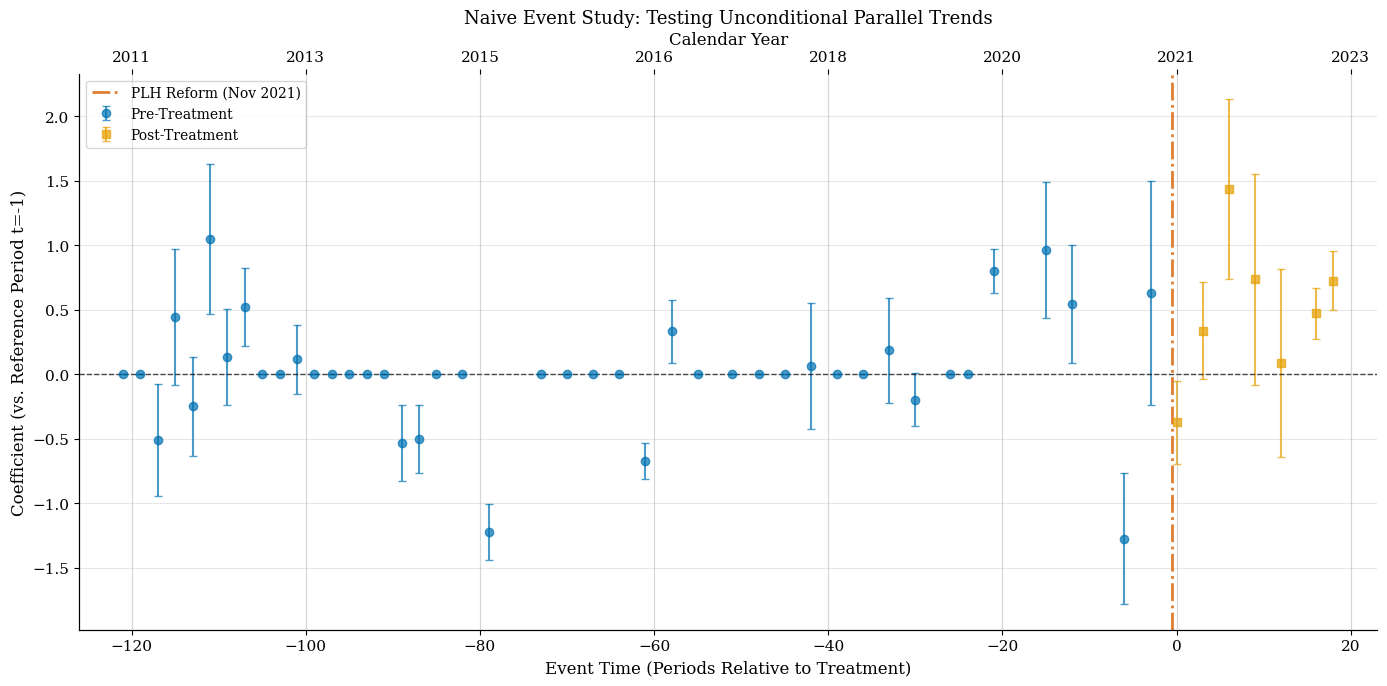

Figure 0 saved: Naive parallel trends event study


In [16]:
# =============================================================================
# PLOT NAIVE EVENT STUDY (Figure 1)
# =============================================================================
fig, ax1 = plt.subplots(figsize=(14, 7))

pre = es_df['event_time'] < 0
post = es_df['event_time'] >= 0

# Pre-treatment (should be near zero if parallel trends holds)
ax1.errorbar(es_df.loc[pre, 'event_time'], es_df.loc[pre, 'coef'],
             yerr=[es_df.loc[pre,'coef']-es_df.loc[pre,'ci_lower'],
                   es_df.loc[pre,'ci_upper']-es_df.loc[pre,'coef']],
             fmt='o', ms=6, capsize=3, color=CB_COLORS['blue'],
             ecolor=CB_COLORS['blue'], alpha=0.7, label='Pre-Treatment')

# Post-treatment
ax1.errorbar(es_df.loc[post, 'event_time'], es_df.loc[post, 'coef'],
             yerr=[es_df.loc[post,'coef']-es_df.loc[post,'ci_lower'],
                   es_df.loc[post,'ci_upper']-es_df.loc[post,'coef']],
             fmt='s', ms=6, capsize=3, color=CB_COLORS['orange'],
             ecolor=CB_COLORS['orange'], alpha=0.7, label='Post-Treatment')

ax1.axhline(0, color=CB_COLORS['black'], ls='--', lw=1, alpha=0.7)
ax1.axvline(-0.5, color=CB_COLORS['vermillion'], ls='-.', lw=2, alpha=0.8,
            label='PLH Reform (Nov 2021)')

ax1.set_xlabel('Event Time (Periods Relative to Treatment)')
ax1.set_ylabel('Coefficient (vs. Reference Period t=-1)')
ax1.set_title('Naive Event Study: Testing Unconditional Parallel Trends')

# X-axis ticks
xticks = np.arange(-120, 40, 20)
ax1.set_xticks(xticks)
ax1.set_xlim(es_df['event_time'].min()-5, es_df['event_time'].max()+5)

# Secondary axis (calendar year)
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels([(base_date + pd.DateOffset(months=int(TREATMENT_PERIOD+e))).strftime('%Y')
                     for e in xticks])
ax2.set_xlabel('Calendar Year')

ax1.legend(loc='upper left')
plt.tight_layout()
plt.savefig(OUTPUT/'fig0_naive_parallel_trends.png', dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT/'fig0_naive_parallel_trends.pdf', bbox_inches='tight')
plt.show()

print("Figure 0 saved: Naive parallel trends event study")

---
## Figure 2: CF-DiD Event Study

In [ ]:
# =============================================================================
# CF-DiD EVENT STUDY
# =============================================================================
def compute_event_study(df, outcome, treat, panel, time, features, treat_time, n_boot=150):
    df = df.copy()
    df['et'] = df[time] - treat_time

    ctrl = df[df[treat]==0]
    td = pd.get_dummies(ctrl[time], prefix='t')
    td_cols = td.columns.tolist()
    X = np.hstack([ctrl[features].values, td.values])
    rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, random_state=42, n_jobs=-1)
    rf.fit(X, ctrl[outcome].values)

    treated = df[df[treat]==1]
    results = []
    for et in sorted(treated['et'].unique()):
        p = treated[treated['et']==et]
        if len(p)==0: continue
        td_p = pd.get_dummies(p[time], prefix='t')
        for c in td_cols:
            if c not in td_p.columns: td_p[c]=0
        td_p = td_p.reindex(columns=td_cols, fill_value=0)
        X_p = np.hstack([p[features].values, td_p.values])
        eff = np.mean(p[outcome].values - rf.predict(X_p))
        results.append({'event_time': et, 'effect': eff, 'n': len(p)})

    es = pd.DataFrame(results)

    # Bootstrap
    boot_eff = {e: [] for e in es['event_time']}
    for b in range(n_boot):
        panels = df[panel].unique()
        samp = np.random.choice(panels, len(panels), True)
        bdf = pd.concat([df[df[panel]==p] for p in samp])
        bdf['et'] = bdf[time] - treat_time

        bc = bdf[bdf[treat]==0]
        btd = pd.get_dummies(bc[time], prefix='t')
        for c in td_cols:
            if c not in btd.columns: btd[c]=0
        btd = btd.reindex(columns=td_cols, fill_value=0)
        bX = np.hstack([bc[features].values, btd.values])
        brf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42+b, n_jobs=-1)
        brf.fit(bX, bc[outcome].values)

        bt = bdf[bdf[treat]==1]
        for et in es['event_time']:
            bp = bt[bt['et']==et]
            if len(bp)==0: boot_eff[et].append(np.nan); continue
            btd_p = pd.get_dummies(bp[time], prefix='t')
            for c in td_cols:
                if c not in btd_p.columns: btd_p[c]=0
            btd_p = btd_p.reindex(columns=td_cols, fill_value=0)
            bX_p = np.hstack([bp[features].values, btd_p.values])
            boot_eff[et].append(np.mean(bp[outcome].values - brf.predict(bX_p)))

    es['se'] = [np.nanstd(boot_eff[e]) for e in es['event_time']]
    es['ci_lo'] = [np.nanpercentile(boot_eff[e], 2.5) for e in es['event_time']]
    es['ci_hi'] = [np.nanpercentile(boot_eff[e], 97.5) for e in es['event_time']]
    return es

print("Computing event study...")
es_df = compute_event_study(analysis_df_clean, 'log_prob_first', 'everprime',
                            'panel_id', 'time_period', FEATURES, TREATMENT_PERIOD, 150)
print(f"Done: {len(es_df)} periods")

Computing event study...
Done: 27 periods


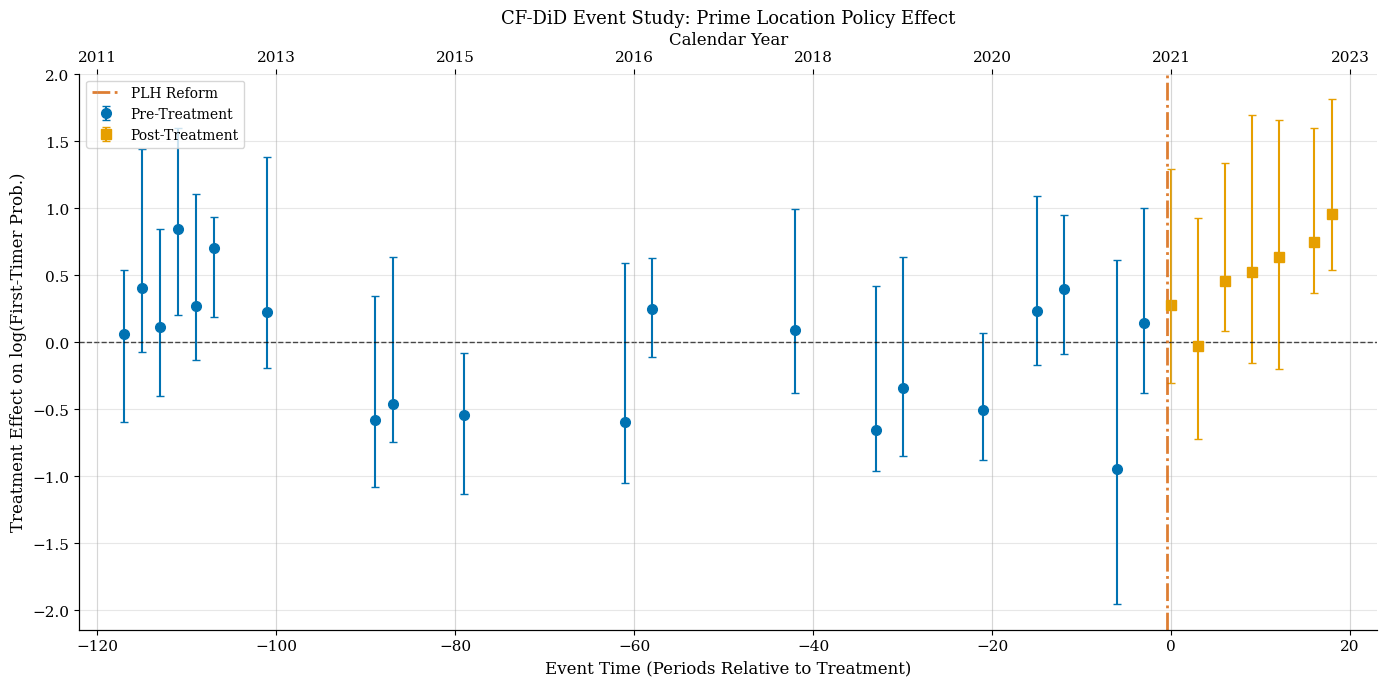

Figure 2 saved.


In [ ]:
# =============================================================================
# PLOT EVENT STUDY (Dual X-axis)
# =============================================================================
fig, ax1 = plt.subplots(figsize=(14, 7))

pre = es_df['event_time'] < 0
post = es_df['event_time'] >= 0

ax1.errorbar(es_df.loc[pre, 'event_time'], es_df.loc[pre, 'effect'],
             yerr=[es_df.loc[pre,'effect']-es_df.loc[pre,'ci_lo'], es_df.loc[pre,'ci_hi']-es_df.loc[pre,'effect']],
             fmt='o', ms=7, capsize=3, color=CB_COLORS['blue'], ecolor=CB_COLORS['blue'], label='Pre-Treatment')
ax1.errorbar(es_df.loc[post, 'event_time'], es_df.loc[post, 'effect'],
             yerr=[es_df.loc[post,'effect']-es_df.loc[post,'ci_lo'], es_df.loc[post,'ci_hi']-es_df.loc[post,'effect']],
             fmt='s', ms=7, capsize=3, color=CB_COLORS['orange'], ecolor=CB_COLORS['orange'], label='Post-Treatment')

ax1.axhline(0, color=CB_COLORS['black'], ls='--', lw=1, alpha=0.7)
ax1.axvline(-0.5, color=CB_COLORS['vermillion'], ls='-.', lw=2, alpha=0.8, label='PLH Reform')

ax1.set_xlabel('Event Time (Periods Relative to Treatment)')
ax1.set_ylabel('Treatment Effect on log(First-Timer Prob.)')
ax1.set_title('CF-DiD Event Study: Prime Location Policy Effect')

xticks = np.arange(-120, 40, 20)
ax1.set_xticks(xticks)
ax1.set_xlim(es_df['event_time'].min()-5, es_df['event_time'].max()+5)

# Secondary axis (calendar)
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
base = df['date'].min()
ax2.set_xticks(xticks)
ax2.set_xticklabels([(base + pd.DateOffset(months=int(TREATMENT_PERIOD+e))).strftime('%Y') for e in xticks])
ax2.set_xlabel('Calendar Year')

ax1.legend(loc='upper left')
plt.tight_layout()
plt.savefig(OUTPUT/'fig2_cfdid_event_study.png', dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT/'fig2_cfdid_event_study.pdf', bbox_inches='tight')
plt.show()
print("Figure 2 saved.")

---
## Figure 3: Placebo Test

In [ ]:
# =============================================================================
# PLACEBO TEST
# =============================================================================
def run_placebo_tests(df, outcome, treat, panel, time, features, true_time, n_placebo=8, n_boot=100):
    pre = df[df[time] < true_time].copy()
    times = sorted(pre[time].unique())
    margin = max(2, len(times)//5)
    candidates = times[margin:-margin]

    np.random.seed(42)
    placebo_times = sorted(np.random.choice(candidates, min(n_placebo, len(candidates)), False))

    results = []
    for pt in placebo_times:
        pdf = pre.copy()
        pdf['fake_post'] = (pdf[time] >= pt).astype(int)
        try:
            m = CausalForestDiD(n_trees=200, n_bootstrap=n_boot)
            m.fit(pdf, outcome, treat, 'fake_post', panel, time, features)
            results.append({'time': pt, 'effect': m.att, 'se': m.se,
                           'ci_lo': m.ci_lower, 'ci_hi': m.ci_upper,
                           'sig': (m.ci_lower>0)|(m.ci_upper<0)})
        except: pass
    return pd.DataFrame(results), placebo_times

print("Running placebo tests...")
placebo_df, placebo_times = run_placebo_tests(analysis_df_clean, 'log_prob_first', 'everprime',
                                              'panel_id', 'time_period', FEATURES, TREATMENT_PERIOD)
print(f"Done: {len(placebo_df)} placebos, {placebo_df['sig'].sum()} significant")

Running placebo tests...
Done: 8 placebos, 0 significant


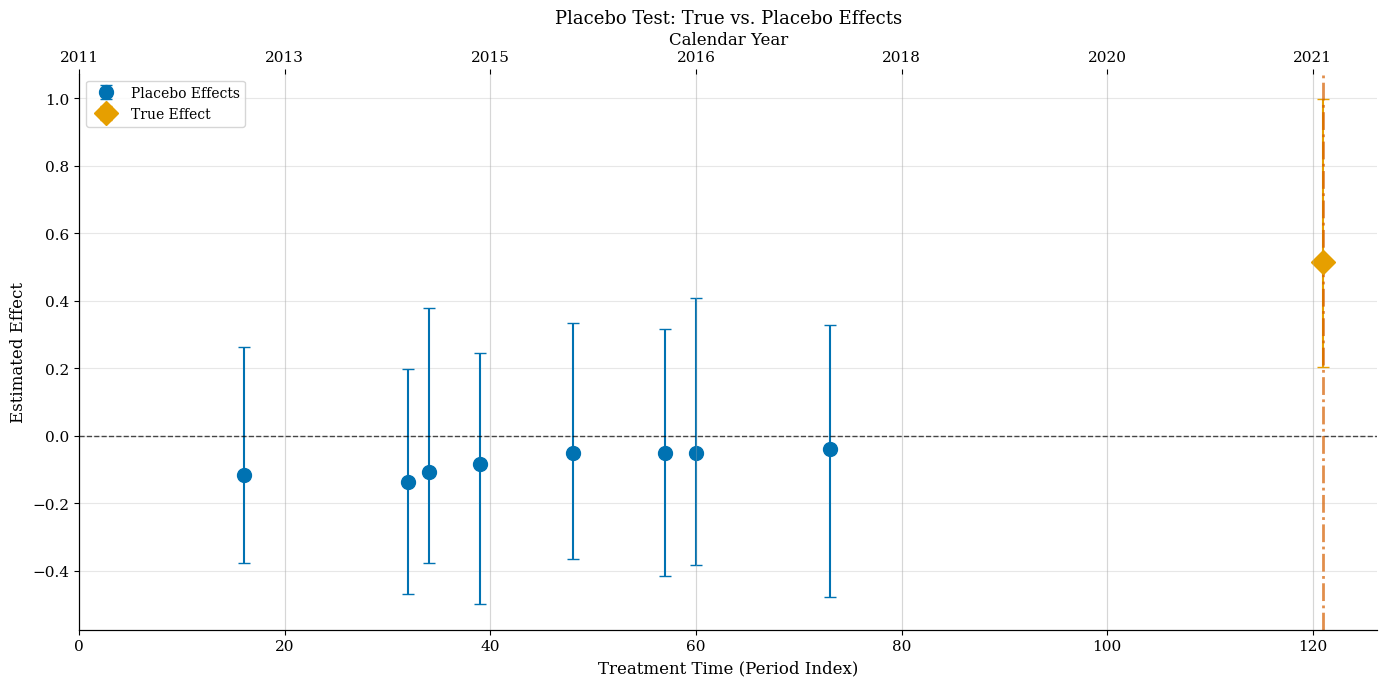

Figure 3 saved.


In [ ]:
# =============================================================================
# PLOT PLACEBO TEST
# =============================================================================
# Combine with true effect
placebo_df['is_true'] = False
true_row = pd.DataFrame([{'time': TREATMENT_PERIOD, 'effect': cfdid.att, 'se': cfdid.se,
                          'ci_lo': cfdid.ci_lower, 'ci_hi': cfdid.ci_upper, 'sig': True, 'is_true': True}])
combined = pd.concat([placebo_df, true_row]).sort_values('time')

fig, ax1 = plt.subplots(figsize=(14, 7))

plac = ~combined['is_true']
true = combined['is_true']

ax1.errorbar(combined.loc[plac, 'time'], combined.loc[plac, 'effect'],
             yerr=[combined.loc[plac,'effect']-combined.loc[plac,'ci_lo'], combined.loc[plac,'ci_hi']-combined.loc[plac,'effect']],
             fmt='o', ms=10, capsize=4, color=CB_COLORS['blue'], ecolor=CB_COLORS['blue'], label='Placebo Effects')
ax1.errorbar(combined.loc[true, 'time'], combined.loc[true, 'effect'],
             yerr=[combined.loc[true,'effect']-combined.loc[true,'ci_lo'], combined.loc[true,'ci_hi']-combined.loc[true,'effect']],
             fmt='D', ms=12, capsize=4, color=CB_COLORS['orange'], ecolor=CB_COLORS['orange'], label='True Effect')

ax1.axhline(0, color=CB_COLORS['black'], ls='--', lw=1, alpha=0.7)
ax1.axvline(TREATMENT_PERIOD, color=CB_COLORS['vermillion'], ls='-.', lw=2, alpha=0.7)

ax1.set_xlabel('Treatment Time (Period Index)')
ax1.set_ylabel('Estimated Effect')
ax1.set_title('Placebo Test: True vs. Placebo Effects')

xticks = np.arange(0, 140, 20)
ax1.set_xticks(xticks)

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels([(df['date'].min()+pd.DateOffset(months=int(t))).strftime('%Y') for t in xticks])
ax2.set_xlabel('Calendar Year')

ax1.legend(loc='upper left')
plt.tight_layout()
plt.savefig(OUTPUT/'fig3_placebo_test.png', dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT/'fig3_placebo_test.pdf', bbox_inches='tight')
plt.show()
print("Figure 3 saved.")

---
## Anticipation Effects Test

In [ ]:
# =============================================================================
# ANTICIPATION TEST
# =============================================================================
df_ant = analysis_df_clean.copy()
ant_start = TREATMENT_PERIOD - 6
df_ant['antic'] = ((df_ant['time_period']>=ant_start) & (df_ant['time_period']<TREATMENT_PERIOD)).astype(int)
df_ant['post_treat'] = (df_ant['time_period']>=TREATMENT_PERIOD).astype(int)
df_ant['treat_antic'] = df_ant['everprime'] * df_ant['antic']
df_ant['treat_post'] = df_ant['everprime'] * df_ant['post_treat']

model = smf.ols('log_prob_first ~ treat_antic + treat_post + C(panel_id) + C(time_period)',
                data=df_ant).fit(cov_type='cluster', cov_kwds={'groups': df_ant['panel_id']})

print("="*60)
print("ANTICIPATION EFFECTS TEST")
print("="*60)
print(f"Anticipation coef: {model.params['treat_antic']:.4f} (SE={model.bse['treat_antic']:.4f})")
print(f"p-value: {model.pvalues['treat_antic']:.4f}")
print(f"Post-treatment coef: {model.params['treat_post']:.4f} (SE={model.bse['treat_post']:.4f})")
print(f"p-value: {model.pvalues['treat_post']:.4f}")
print("\nConclusion:", "No anticipation effects" if model.pvalues['treat_antic']>0.05 else "Anticipation detected")

ANTICIPATION EFFECTS TEST
Anticipation coef: -0.2171 (SE=0.4340)
p-value: 0.6169
Post-treatment coef: 0.4502 (SE=0.1424)
p-value: 0.0016

Conclusion: No anticipation effects


---
## LaTeX Tables

In [ ]:
# =============================================================================
# LATEX TABLE: MAIN RESULTS
# =============================================================================
latex = f"""
\\begin{{table}}[htbp]
\\centering
\\caption{{CF-DiD Estimation Results: Effect of PLH Reform}}
\\label{{tab:main_results}}
\\begin{{tabular}}{{lc}}
\\hline\\hline
\\multicolumn{{2}}{{c}}{{\\textbf{{Panel A: Main Results}}}} \\\\
\\hline
ATT Estimate & {cfdid.att:.4f} \\\\
& ({cfdid.se:.4f}) \\\\
95\\% CI & [{cfdid.ci_lower:.4f}, {cfdid.ci_upper:.4f}] \\\\
\\hline
\\multicolumn{{2}}{{c}}{{\\textbf{{Panel B: Placebo Tests}}}} \\\\
\\hline
Number of tests & {len(placebo_df)} \\\\
Significant (p<0.05) & {placebo_df['sig'].sum()} \\\\
Mean placebo effect & {placebo_df['effect'].mean():.4f} \\\\
\\hline
\\multicolumn{{2}}{{c}}{{\\textbf{{Panel C: Anticipation Test}}}} \\\\
\\hline
Anticipation coef & {model.params['treat_antic']:.4f} \\\\
& ({model.bse['treat_antic']:.4f}) \\\\
p-value & {model.pvalues['treat_antic']:.4f} \\\\
\\hline\\hline
\\end{{tabular}}
\\begin{{tablenotes}}
\\small
\\item \\textit{{Notes:}} Standard errors in parentheses (clustered bootstrap, 200 replications).
\\end{{tablenotes}}
\\end{{table}}
"""

with open(OUTPUT/'tab_main_results.tex', 'w') as f:
    f.write(latex)
print("LaTeX table saved.")
print(latex)

LaTeX table saved.

\begin{table}[htbp]
\centering
\caption{CF-DiD Estimation Results: Effect of PLH Reform}
\label{tab:main_results}
\begin{tabular}{lc}
\hline\hline
\multicolumn{2}{c}{\textbf{Panel A: Main Results}} \\
\hline
ATT Estimate & 0.5145 \\
& (0.2228) \\
95\% CI & [0.2035, 0.9986] \\
\hline
\multicolumn{2}{c}{\textbf{Panel B: Placebo Tests}} \\
\hline
Number of tests & 8 \\
Significant (p<0.05) & 0 \\
Mean placebo effect & -0.0800 \\
\hline
\multicolumn{2}{c}{\textbf{Panel C: Anticipation Test}} \\
\hline
Anticipation coef & -0.2171 \\
& (0.4340) \\
p-value & 0.6169 \\
\hline\hline
\end{tabular}
\begin{tablenotes}
\small
\item \textit{Notes:} Standard errors in parentheses (clustered bootstrap, 200 replications).
\end{tablenotes}
\end{table}



In [ ]:
# =============================================================================
# SUMMARY
# =============================================================================
print("="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"\nOutput directory: {OUTPUT}")
print("\nFigures generated:")
print("  1. fig1_descriptive.pdf - Time series by Prime status")
print("  2. fig2_cfdid_event_study.pdf - CF-DiD event study")
print("  3. fig3_placebo_test.pdf - Placebo validation")
print("\nTables generated:")
print("  - tab_main_results.tex")
print("\nKey findings:")
print(f"  ATT = {cfdid.att:.3f} ({(np.exp(cfdid.att)-1)*100:.1f}% increase in allocation prob.)")
print(f"  Placebo tests: {placebo_df['sig'].sum()}/{len(placebo_df)} significant")
print(f"  Anticipation: {'None detected' if model.pvalues['treat_antic']>0.05 else 'Detected'}")

ANALYSIS COMPLETE

Output directory: /content/drive/MyDrive/thesis/FINAL_OUTPUT

Figures generated:
  1. fig1_descriptive.pdf - Time series by Prime status
  2. fig2_cfdid_event_study.pdf - CF-DiD event study
  3. fig3_placebo_test.pdf - Placebo validation

Tables generated:
  - tab_main_results.tex

Key findings:
  ATT = 0.514 (67.3% increase in allocation prob.)
  Placebo tests: 0/8 significant
  Anticipation: None detected


##Figure 4: descriptive time series analysis

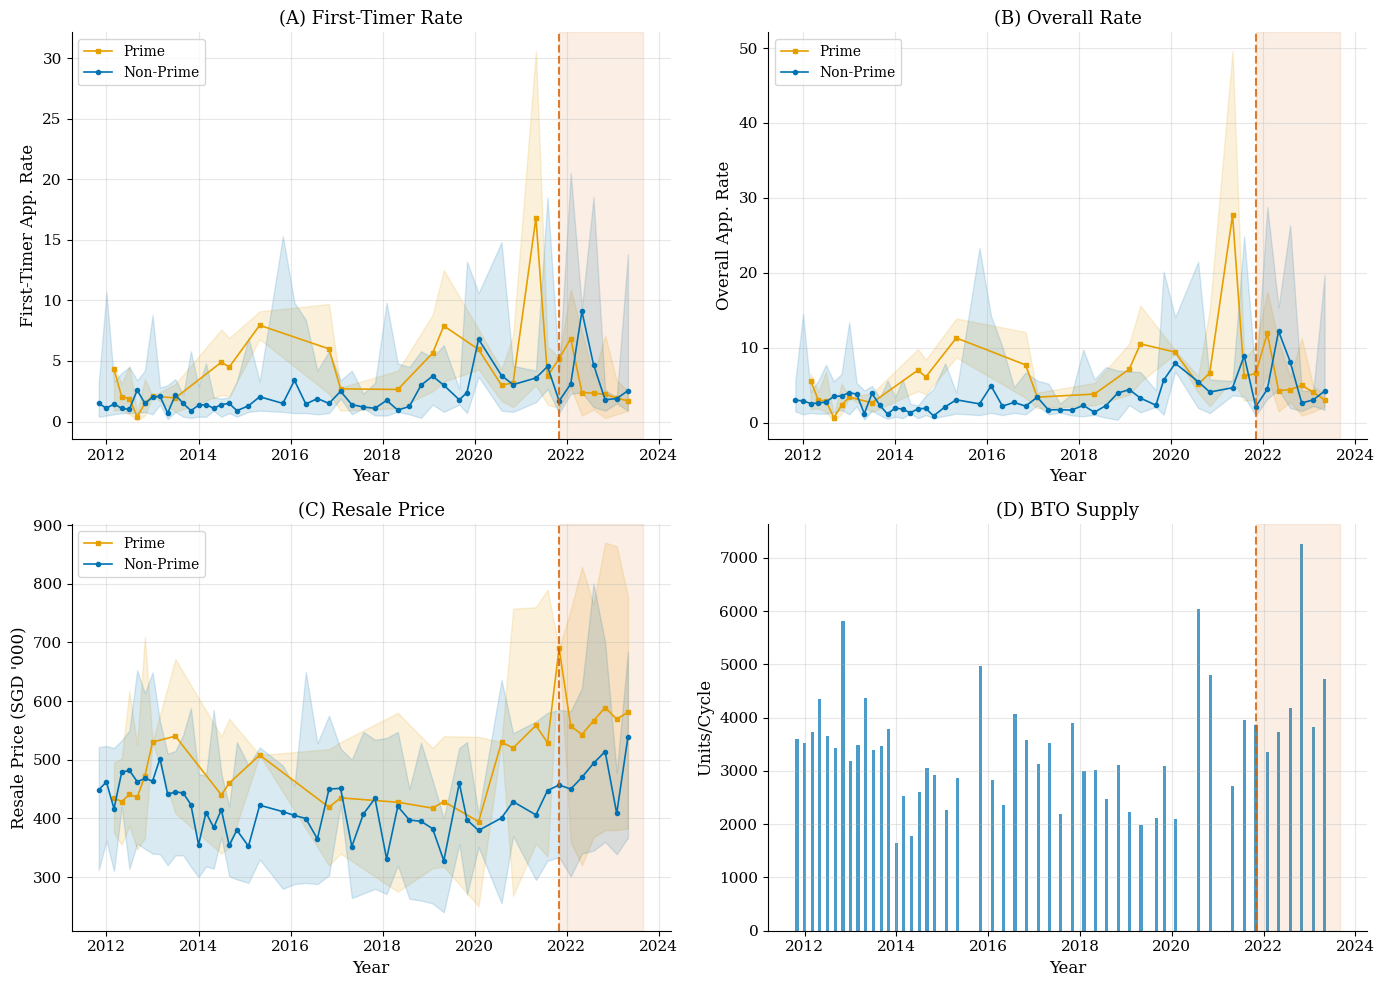

Figure 1 saved.


In [ ]:
# =============================================================================
# FIGURE 4: DESCRIPTIVE TIME SERIES
# =============================================================================
df_desc = df[df['date'] <= '2023-08-31'].copy()
agg = df_desc.groupby(['date', 'everprime']).agg({
    'first_timer_rate': ['median', 'min', 'max'],
    'overall_rate': ['median', 'min', 'max'],
    'median_resale_price': ['median', 'min', 'max']
}).reset_index()
agg.columns = ['_'.join(c).strip('_') if c[1] else c[0] for c in agg.columns]

prime = agg[agg['everprime']==1].sort_values('date')
nonprime = agg[agg['everprime']==0].sort_values('date')
nov21, aug23 = pd.Timestamp('2021-11-01'), pd.Timestamp('2023-08-31')

def shade(ax):
    ax.axvline(nov21, color=CB_COLORS['vermillion'], ls='--', lw=1.5, alpha=0.8)
    ax.axvspan(nov21, aug23, alpha=0.1, color=CB_COLORS['vermillion'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A
ax = axes[0,0]
for d, lbl, col, m in [(prime,'Prime',CB_COLORS['orange'],'s'), (nonprime,'Non-Prime',CB_COLORS['blue'],'o')]:
    ax.plot(d['date'], d['first_timer_rate_median'], color=col, marker=m, ms=3, lw=1.2, label=lbl)
    ax.fill_between(d['date'], d['first_timer_rate_min'], d['first_timer_rate_max'], alpha=0.15, color=col)
shade(ax); ax.set_ylabel('First-Timer App. Rate'); ax.set_title('(A) First-Timer Rate'); ax.legend()

# Panel B
ax = axes[0,1]
for d, lbl, col, m in [(prime,'Prime',CB_COLORS['orange'],'s'), (nonprime,'Non-Prime',CB_COLORS['blue'],'o')]:
    ax.plot(d['date'], d['overall_rate_median'], color=col, marker=m, ms=3, lw=1.2, label=lbl)
    ax.fill_between(d['date'], d['overall_rate_min'], d['overall_rate_max'], alpha=0.15, color=col)
shade(ax); ax.set_ylabel('Overall App. Rate'); ax.set_title('(B) Overall Rate'); ax.legend()

# Panel C
ax = axes[1,0]
for d, lbl, col, m in [(prime,'Prime',CB_COLORS['orange'],'s'), (nonprime,'Non-Prime',CB_COLORS['blue'],'o')]:
    ax.plot(d['date'], d['median_resale_price_median']/1000, color=col, marker=m, ms=3, lw=1.2, label=lbl)
    ax.fill_between(d['date'], d['median_resale_price_min']/1000, d['median_resale_price_max']/1000, alpha=0.15, color=col)
shade(ax); ax.set_ylabel("Resale Price (SGD '000)"); ax.set_title('(C) Resale Price'); ax.legend(loc='upper left')

# Panel D
ax = axes[1,1]
supply = df_desc.groupby('date')['cycle_total_supply'].first().reset_index()
ax.bar(supply['date'], supply['cycle_total_supply'], width=25, color=CB_COLORS['blue'], alpha=0.7)
shade(ax); ax.set_ylabel('Units/Cycle'); ax.set_title('(D) BTO Supply')

for ax in axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.set_xlabel('Year')

plt.tight_layout()
plt.savefig(OUTPUT/'fig1_descriptive.png', dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT/'fig1_descriptive.pdf', bbox_inches='tight')
plt.show()
print("Figure 1 saved.")